In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

100% 247M/247M [00:12<00:00, 20.4MB/s]
100% 247M/247M [00:12<00:00, 19.9MB/s]


In [3]:
! unzip satellite-images-of-water-bodies.zip

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset/Images/water_body_1808.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset/Images/water_body_1822.jpg  
  inf

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import matplotlib.pyplot as plt

In [5]:
import os
import shutil

# set paths to image and mask directories
train_image_dir = '/content/Water Bodies Dataset/Images'
train_mask_dir = '/content/Water Bodies Dataset/Masks'

# create directory for validation data
val_image_dir = '/content/Water Bodies Dataset val/images'
val_mask_dir = '/content/Water Bodies Dataset val/masks'
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

# get list of image and mask file names
image_files = os.listdir(train_image_dir)
mask_files = os.listdir(train_mask_dir)

# sort file names to ensure correspondence between image and mask files
image_files.sort()
mask_files.sort()

# compute number of images to move to validation directory
val_size = int(0.2 * len(image_files))

# move images and masks to validation directory
for i in range(val_size):
    image_file = image_files.pop()
    mask_file = mask_files.pop()
    shutil.move(os.path.join(train_image_dir, image_file), os.path.join(val_image_dir, image_file))
    shutil.move(os.path.join(train_mask_dir, mask_file), os.path.join(val_mask_dir, mask_file))


In [6]:
image_dir = '/content/Water Bodies Dataset/Images'
masks_dir = '/content/Water Bodies Dataset/Masks'


In [7]:
samples = next(os.walk(image_dir))[-1][:10]
masks= next(os.walk(masks_dir))[-1][:10]

In [8]:
j = 0
dir = image_dir 
samples_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  samples_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

In [9]:
j = 0
dir = masks_dir 
masks_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  masks_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

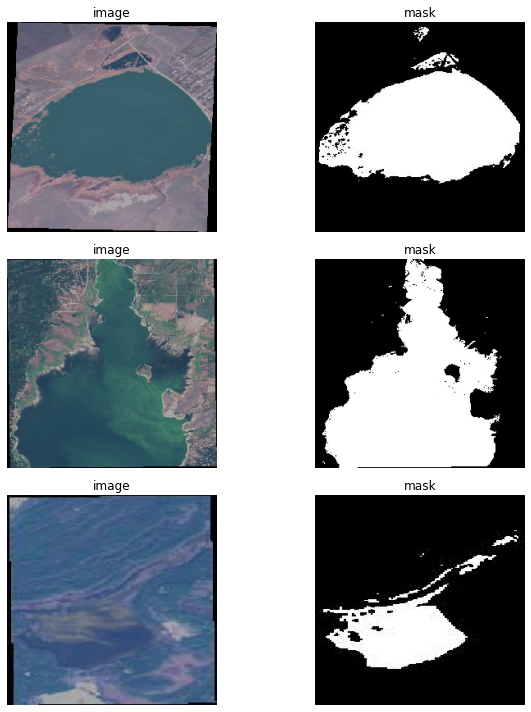

In [10]:
plt.figure(figsize=(10,10))
for i in range(1,7):
    plt.subplot(3,2,i)
    
    if i%2!=0:
        id = np.random.randint(len(samples_))
        plt.imshow(samples_[id])
        plt.title('image')
        plt.axis('off')
    elif i%2==0:
        plt.imshow(masks_[id])
        plt.title('mask')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

def rgb2gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g = np.expand_dims(gray, axis=-1)
    return g

In [12]:
import numpy as np
import cv2
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define image and mask directories


# create an ImageDataGenerator object for data augmentation with histogram equalization
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     rescale=1./255)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args )

# create generator objects
batch_size = 20
seed = 1
image_generator = image_datagen.flow_from_directory('/content/Water Bodies Dataset',classes=['Images'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow_from_directory('/content/Water Bodies Dataset', classes=['Masks'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
image_datagen = ImageDataGenerator(rescale=1./255)
mask_data = ImageDataGenerator()
image_generator_val = image_datagen.flow_from_directory('/content/Water Bodies Dataset val',classes=['images'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
mask_generator_val = mask_data.flow_from_directory('/content/Water Bodies Dataset val',classes=['masks'], target_size=(224, 224), class_mode=None, batch_size=batch_size, seed=seed)
# combine generators into one which yields image and mask
def binarize_mask(mask):
    threshold = 0.5
    binary_mask = np.where(mask > 0.5, 1, 0)
    return binary_mask
mask_generator = map(binarize_mask, mask_generator)
mask_generator_val = map(binarize_mask, mask_generator_val)
train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_generator_val, mask_generator_val)

# train your model using the train_generator


Found 2273 images belonging to 1 classes.
Found 2273 images belonging to 1 classes.
Found 568 images belonging to 1 classes.
Found 568 images belonging to 1 classes.


In [35]:
samples = next(os.walk('/content/Water Bodies Dataset val/images'))[-1][:10]

In [36]:
j = 0
dir = '/content/Water Bodies Dataset val/images'
a = np.zeros(shape=(len(samples),224,224, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (224, 224),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  a[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import Layer

# class Threshold(Layer):
#     def __init__(self, threshold=0.5, **kwargs):
#         super().__init__(**kwargs)
#         self.threshold = threshold

#     def call(self, inputs):
#         return tf.keras.backend.switch(inputs > self.threshold, tf.ones_like(inputs), tf.zeros_like(inputs))

#     def get_config(self):
#         config = super().get_config()
#         config['threshold'] = self.threshold
#         return config

In [14]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [15]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

In [47]:
def unet_model(input_size=(224, 224, 3), n_filters=32):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    # conv10 = Threshold(threshold=0.5)(conv10)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [17]:
# from tensorflow.keras import backend as K
# def iou_threshold(threshold=0.5):
#     def iou(y_true, y_pred):
#         y_pred_thresh = K.cast(y_pred > threshold, dtype='float32')
#         intersection = K.sum(K.abs(y_true * y_pred_thresh), axis=[1, 2, 3])
#         union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred_thresh, axis=[1, 2, 3]) - intersection
#         iou = K.mean((intersection + K.epsilon()) / (union + K.epsilon()))
#         return iou
#     return iou

In [18]:
# from tensorflow.keras.models import Sequential
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(UpSampling2D((2, 2)))

In [48]:
model = unet_model(n_filters=32,input_size=(224,224,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [20]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [21]:
# len(next(os.walk(image_dir))[-1])

2273

In [49]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint1]

In [50]:
history1 = model.fit(train_generator, validation_data = val_generator, epochs=10 ,steps_per_epoch = 142,validation_steps = 30 , callbacks=callbacks)

Epoch 1/10
 31/142 [=====>........................] - ETA: 57s - loss: 0.5746 - accuracy: 0.6869

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# assume you have a list of test images and their predicted segmentation masks

predicted_masks = model.predict(a)  # a list of predicted segmentation masks

# set up the figure and axes for plotting
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

# iterate over each test image and its predicted mask, and plot them side by side
for i, (image, mask) in enumerate(zip(a, predicted_masks)):
    # plot the test image on the left
    axes[i][0].imshow(image)
    axes[i][0].set_title("Test Image")
    axes[i][0].axis("off")
    
    # plot the predicted mask on the right
    mask = np.squeeze(mask, axis=-1)  # remove the last dimension if it's a grayscale mask
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Predicted Mask")
    axes[i][1].axis("off")

# display the figure
plt.tight_layout()
plt.show()

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Add, UpSampling2D, Input, ZeroPadding2D, GlobalAveragePooling2D

In [31]:
def build_deeplabv3_resnet(input_shape, num_classes):
    # Load ResNet50 model and freeze its weights
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet.trainable = False

    # Create DeepLabv3 decoder
    inputs = Input(shape=input_shape)
    x = resnet(inputs)

    # ASPP Module
    x1 = Conv2D(filters=256, kernel_size=1, padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same')(x)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same')(x)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x4 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same')(x)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    x = tf.keras.layers.concatenate([x1, x2, x3, x4], axis=-1)

    # Convolutional layers
    x = Conv2D(filters=256, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = resnet.layers[49].output
    x_skip = Conv2D(filters=48, kernel_size=1, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)
    x_skip = Activation('relu')(x_skip)

    x = tf.keras.layers.concatenate([x, x_skip], axis=-1)

    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_skip = resnet.layers[15].output
    x_skip = Conv2D(filters=48, kernel_size=1, padding='same')(x_skip)
    x_skip = BatchNormalization()(x_skip)
    x_skip = Activation('relu')(x_skip)

    x = tf.keras.layers.concatenate([x, x_skip], axis=-1)

    x = Conv2D(filters=num_classes, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model


In [32]:
res = unet_model((224,224,3) , 1)

res.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [23]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint2]

In [33]:
history = res.fit(train_generator, validation_data = val_generator, epochs=10 ,steps_per_epoch = 142,validation_steps = 30 , callbacks=callbacks)

Epoch 1/10
142/142 [==============================] - 76s 485ms/step - loss: 0.6226 - accuracy: 0.6696 - val_loss: 0.6296 - val_accuracy: 0.6080
Epoch 2/10
142/142 [==============================] - 63s 450ms/step - loss: 0.5396 - accuracy: 0.6716 - val_loss: 0.6058 - val_accuracy: 0.7002
Epoch 3/10
142/142 [==============================] - 59s 421ms/step - loss: 0.5244 - accuracy: 0.7524 - val_loss: 0.5871 - val_accuracy: 0.7420
Epoch 4/10
142/142 [==============================] - 71s 501ms/step - loss: 0.4984 - accuracy: 0.7867 - val_loss: 0.5781 - val_accuracy: 0.7552
Epoch 5/10
142/142 [==============================] - 69s 491ms/step - loss: 0.4861 - accuracy: 0.7962 - val_loss: 0.5656 - val_accuracy: 0.7614
Epoch 6/10
142/142 [==============================] - 65s 460ms/step - loss: 0.4802 - accuracy: 0.7989 - val_loss: 0.5582 - val_accuracy: 0.7686
Epoch 7/10
142/142 [==============================] - 70s 496ms/step - loss: 0.4682 - accuracy: 0.8064 - val_loss: 0.5295 - val_ac

1/1 [==============================] - 1s 552ms/step


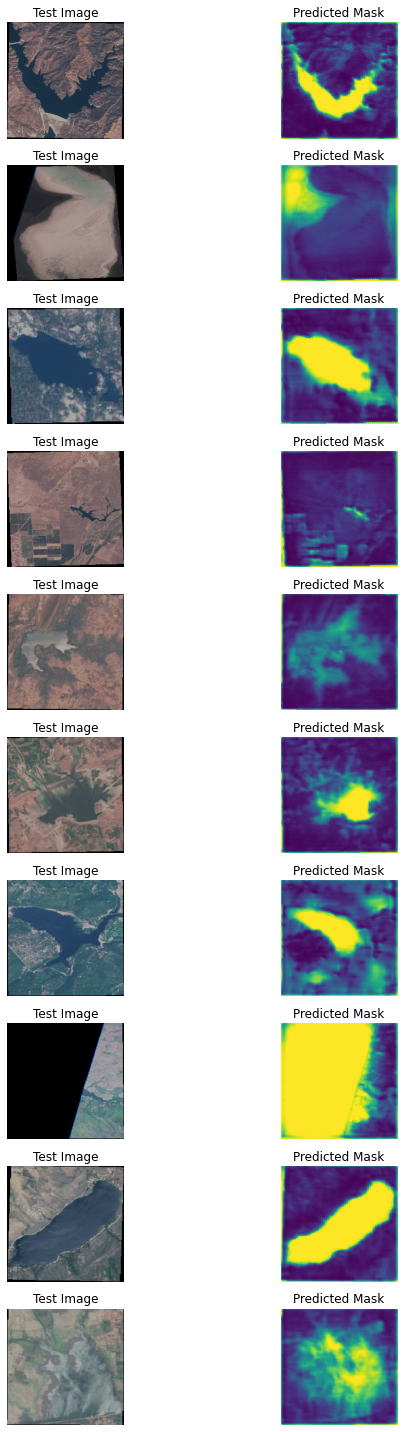

In [37]:
predicted_masks = res.predict(a)  # a list of predicted segmentation masks

# set up the figure and axes for plotting
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

# iterate over each test image and its predicted mask, and plot them side by side
for i, (image, mask) in enumerate(zip(a, predicted_masks)):
    # plot the test image on the left
    axes[i][0].imshow(image)
    axes[i][0].set_title("Test Image")
    axes[i][0].axis("off")
    
    # plot the predicted mask on the right
    mask = np.squeeze(mask, axis=-1)  # remove the last dimension if it's a grayscale mask
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Predicted Mask")
    axes[i][1].axis("off")

# display the figure
plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np
# import cv2
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# # Load test images
# test_images = [cv2.imread('image1.jpg'), cv2.imread('image2.jpg'), cv2.imread('image3.jpg')]

# # Define number of clusters
# num_clusters = 2

# # Define feature extraction function (mean color)
# def get_features(image):
#     return np.mean(image.reshape(-1, 3), axis=0)

# # Define clustering function (K-means)
# def cluster(features):
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0)
#     labels = kmeans.fit_predict(features)
#     return labels

# # Define evaluation function (silhouette score)
# def evaluate(labels, features):
#     return silhouette_score(features, labels)

# # Define model predictions function
# def get_predictions(model, images):
#     predictions = []
#     for image in images:
#         # Apply model to obtain segmentation mask
#         mask = model.predict(image)
#         # Convert mask to feature vector
#         features = get_features(mask)
#         predictions.append(features)
#     return np.array(predictions)

# # Define models to compare
# models = [unet_resnet, unet_vgg19, deeplab_v3]

# # Train models and obtain predictions
# predictions = []
# for model in models:
#     # Train model on labeled dataset
#     model.fit(X_train, y_train)
#     # Obtain predictions on test images
#     model_predictions = get_predictions(model, test_images)
#     predictions.append(model_predictions)

# # Evaluate performance of clustering algorithm on each model's predictions
# for i, model_predictions in enumerate(predictions):
#     # Apply clustering algorithm
#     labels = cluster(model_predictions)
#     # Evaluate clustering performance
#     score = evaluate(labels, model_predictions)
#     print(f'Model {i}: Silhouette score = {score}')


In [ ]:
# import matplotlib.pyplot as plt

# # Define color map for clusters
# cmap = plt.get_cmap('tab10')

# # Define function to plot results
# def plot_results(features, labels):
#     # Plot each feature vector as a point
#     for i, (feature, label) in enumerate(zip(features, labels)):
#         color = cmap(label)
#         plt.scatter(feature[0], feature[1], color=color, s=50)
#     # Set axis labels
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     # Show plot
#     plt.show()

# # Apply clustering algorithm
# features = np.random.rand(100, 2) # Replace with your own feature vectors
# labels = cluster(features) # Replace with your own clustering algorithm

# # Plot results
# plot_results(features, labels)


In [45]:
def build_unet_resnet(input_shape, num_classes):
    # Load ResNet50 model and freeze its weights
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    resnet.trainable = False

    # Create UNet decoder
    inputs = tf.keras.Input(shape=input_shape)
    x1 = resnet.get_layer('conv4_block6_out').output
    x2 = resnet.get_layer('conv3_block4_out').output
    x3 = resnet.get_layer('conv2_block3_out').output
    x4 = resnet.get_layer('conv1_relu').output

    x = Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same')(x1)
    x = concatenate([x, x2])
    x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = concatenate([x, x3])
    x = Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
    x = concatenate([x, x4])
    x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [39]:
checkpoint3 = ModelCheckpoint('model3.h5', monitor='val_loss', save_best_only=True)
callbacks = [checkpoint3]

In [46]:
res_unet = build_unet_resnet((224,224,3) , 1)

res_unet.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

ValueError: ignored

In [ ]:
history = res_unet.fit(train_generator, validation_data = val_generator, epochs=10 ,steps_per_epoch = 142,validation_steps = 30 , callbacks=callbacks)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# assume you have a list of test images and their predicted segmentation masks

predicted_masks = res_unet.predict(a)  # a list of predicted segmentation masks

# set up the figure and axes for plotting
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

# iterate over each test image and its predicted mask, and plot them side by side
for i, (image, mask) in enumerate(zip(a, predicted_masks)):
    # plot the test image on the left
    axes[i][0].imshow(image)
    axes[i][0].set_title("Test Image")
    axes[i][0].axis("off")
    
    # plot the predicted mask on the right
    mask = np.squeeze(mask, axis=-1)  # remove the last dimension if it's a grayscale mask
    axes[i][1].imshow(mask)
    axes[i][1].set_title("Predicted Mask")
    axes[i][1].axis("off")

# display the figure
plt.tight_layout()
plt.show()
